### Imports

In [1]:
import timeit
import numpy as np
import pandas as pd
import altair as alt
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

INPUT_PATH = "../data/input"
OUTPUT_PATH = "../data/output"
TRAIN_FILE_PATH = f"{INPUT_PATH}/train.csv"
TEST_FILE_PATH = f"{INPUT_PATH}/test.csv"
SUBMISSION_FILE_PATH = f"{OUTPUT_PATH}/submission-imputers.csv"
alt.data_transformers.enable('data_server')

# alt.data_transformers.enable(max_rows=None)
alt.renderers.enable('mimetype')


/Users/navyadahiya/opt/miniconda3/envs/571/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


RendererRegistry.enable('mimetype')

### Data

In [2]:
train_df = pd.read_csv(TRAIN_FILE_PATH)
test_df = pd.read_csv(TEST_FILE_PATH)

### Exploratory Data Analysis

**Analysing the missing values in each column of the training data**

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

**Summarising the training data**

In [4]:
train_df.describe()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,1.659839e+05,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,...,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,2.468758e+05,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,...,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,6.237900e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,...,72.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,88.000000,54.528601,18939.000000
50%,5.000000,9.136700e+04,1951.000000,67.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,...,84.000000,12.000000,0.000000,0.000000,1.000000,1.000000,1.000000,104.000000,75.293716,37878.000000
75%,6.000000,1.660000e+05,1977.000000,85.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,...,97.000000,17.000000,0.000000,0.000000,1.000000,1.000000,1.000000,131.000000,97.277534,56817.000000
max,6.000000,6.385382e+06,2015.000000,100.000000,1924.500000,49.000000,64.758065,91.000000,48.000000,65.107143,...,260.000000,185.000000,119.000000,16.000000,360.000000,360.000000,23.300000,311.000000,997.866120,75756.000000


**Checking the correlation between temperature features along with target `site_eui`**

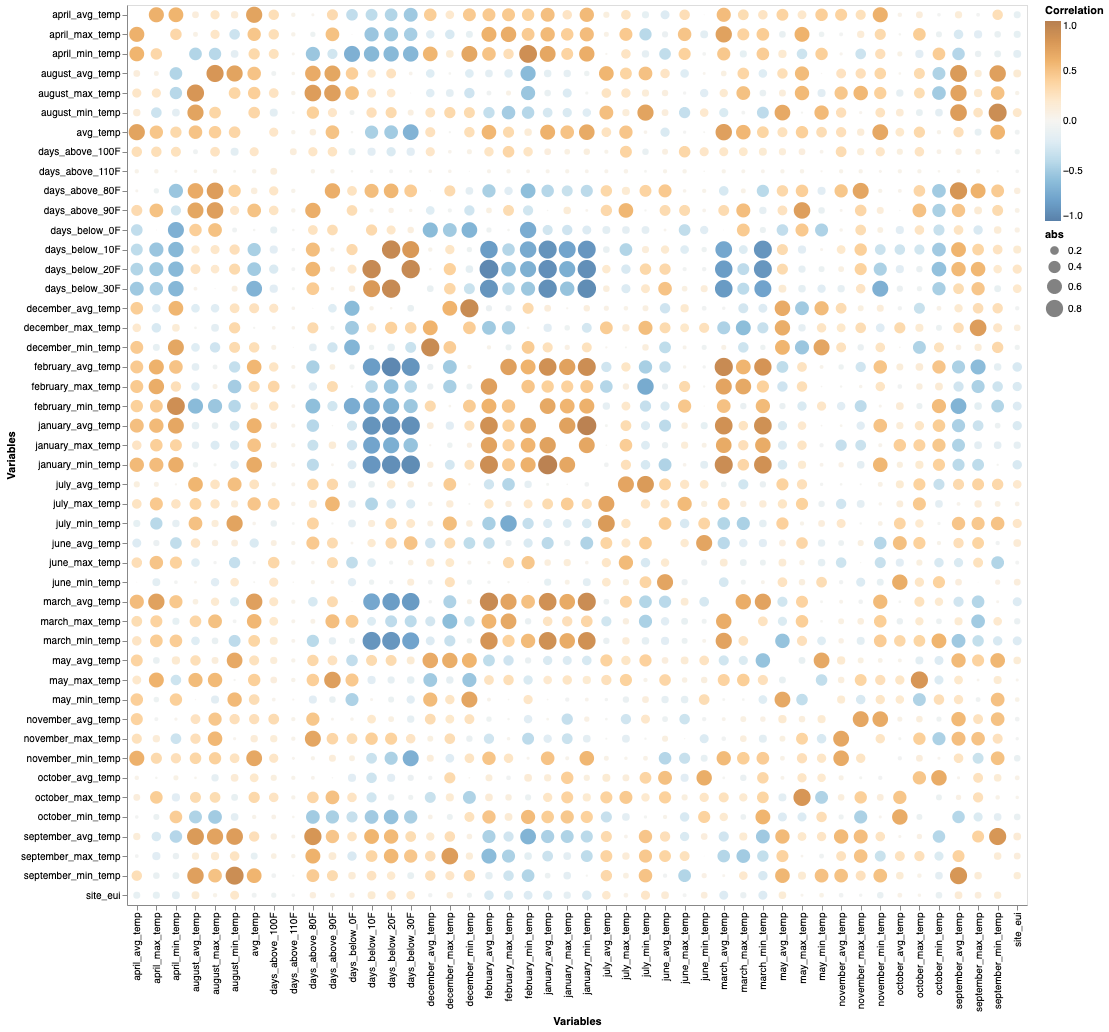

In [5]:
train_df_numeric = train_df.select_dtypes("number")
train_df_filtered = (
    train_df.filter(regex="site|_temp|days_above_|days_below_")
)

corr_df = (
    train_df_filtered
    .corr("spearman")
    .stack()
    .reset_index(name="corr")
)
corr_df.loc[corr_df["corr"] == 1, "corr"] = 0
corr_df["abs"] = corr_df["corr"].abs()

(
    alt.Chart(corr_df)
    .mark_circle()
    .encode(x = alt.X("level_0", title="Variables"),
            y = alt.Y("level_1", title="Variables"),
            size = "abs",
            color = alt.Color(
                'corr',
                scale=alt.Scale(scheme = 'blueorange',
                                domain = (-1, 1)),
                title="Correlation")
           )
).properties(
    width=900,
    height=900
)

**Checking the correlation between other features along with the target `site_eui`**

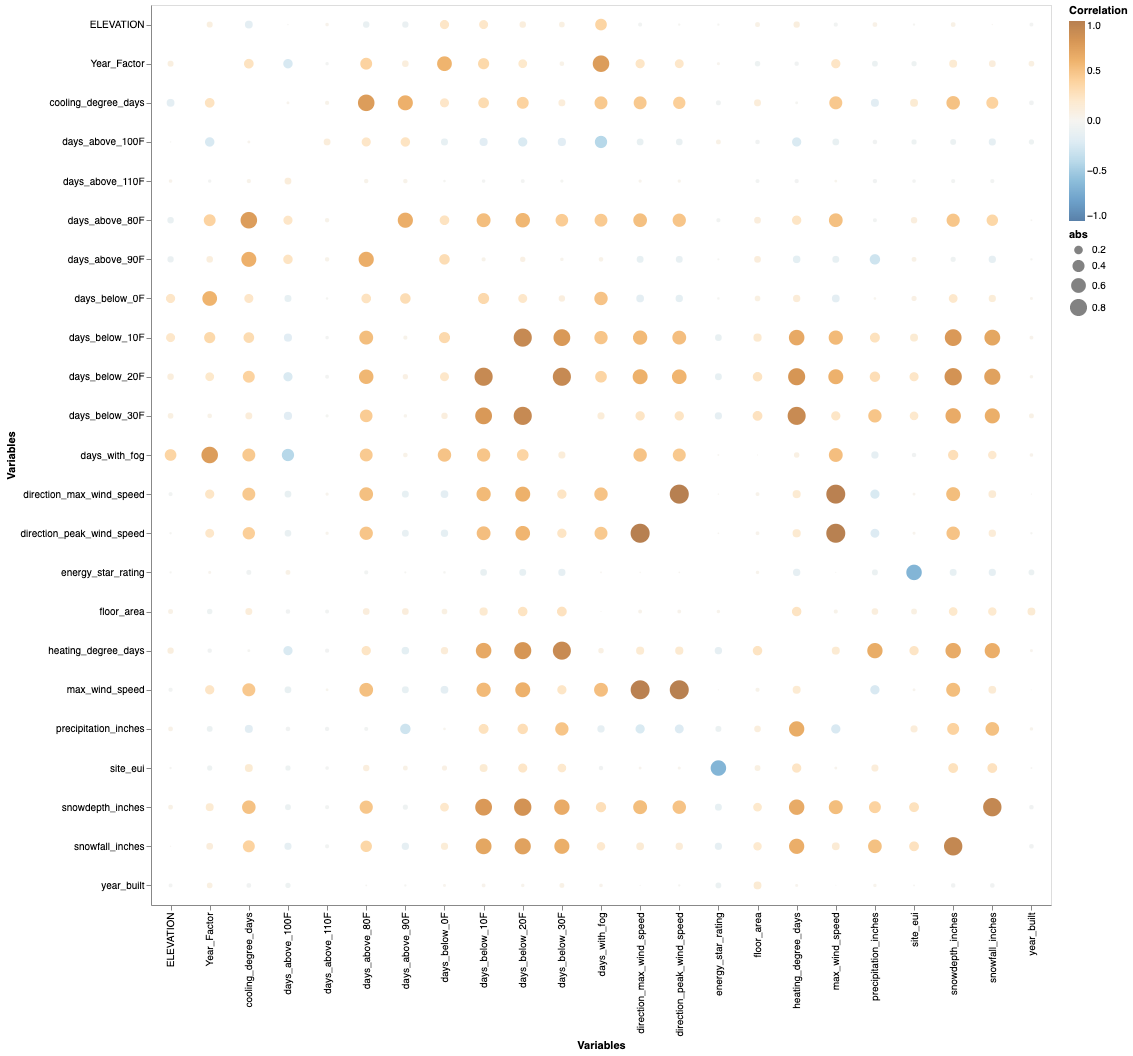

In [6]:
train_df_filtered = (
    train_df_numeric.filter(regex="^(?!.*_temp|id).*$")
)
corr_df = (
    train_df_filtered
    .corr("spearman")
    .stack()
    .reset_index(name="corr")
)
corr_df.loc[corr_df["corr"] == 1, "corr"] = 0
corr_df["abs"] = corr_df["corr"].abs()

(
    alt.Chart(corr_df)
    .mark_circle()
    .encode(x = alt.X("level_0", title="Variables"),
            y = alt.Y("level_1", title="Variables"),
            size = "abs",
            color = alt.Color(
                'corr',
                scale=alt.Scale(scheme = 'blueorange',
                                domain = (-1, 1)),
                title="Correlation")
           )
).properties(
    width = 900,
    height = 900
)

**After checking whether the training data is representative of the test data we want to predict, filtered the `State_6` records which wasn't available in the test data**

In [7]:
train_df = train_df.query("State_Factor != 'State_6'")

**Creating more categories in `building_class` feature based on the feature `facility_type`**

In [8]:
replace = dict(zip([
    'Education_.*',
    '.*(f|F)ood_.*',
    'Health_Care_.*',
    'Lodging_.*',
    'Office_.*',
    '(Public_|Religious).*',
    'Retail_.*',
    'Service_.*',
    'Warehouse_.*',
    '.*_Unit_.*',
    'Mixed_Use_.*',
    ], [
    'Commercial_Education',
    'Commercial_Food',
    'Commercial_Health',
    'Commercial_Hotel',
    'Commercial_Office',
    'Commercial_Public',
    'Commercial_Retail',
    'Commercial_Service',
    'Commercial_Warehouse',
    'Residential_Unit',
    'Residential_Mixed',
    ]))

replace.update({
    'Commercial_Unknown': 'Commercial_Other',
    'Data_Center': 'Commercial_DC',
    'Industrial': 'Commercial_Industrial',
    'Laboratory': 'Commercial_Lab',
    'Nursing_Home': 'Commercial_Home',
    'Parking_Garage': 'Commercial_Parking',
    'Multifamily_Uncategorized': 'Residential_Multifamily',
    })

train_df['building_class'] = train_df['facility_type'].replace(
    replace,
    regex=True
)
test_df['building_class'] = test_df['facility_type'].replace(
    replace,
    regex=True
)

**Filtering out the old records and outliers**

In [9]:
# Note: We are not filling NAs with 2016, we are just using 2016 as a proxy
#       to avoid removing the NA records while filtering.
year = train_df["year_built"].fillna(2016)
train_df = train_df.loc[(year <= 2016) & (year >= 1845)]

In [10]:
state_factor = train_df["State_Factor"]

**Creating a new feature called `building_ID`s by concatenating features that uniquely identify a building**

In [11]:
def make_building_ids(data, columns):
    full_col_name = None
    for column in columns:
        if full_col_name is None:
            full_col_name = data[column].astype(str)
        else:
            full_col_name += '_' + data[column].astype(str)
    return full_col_name


buidling_columns = ['State_Factor', 'building_class', 'facility_type',
                    'year_built', 'floor_area']

train_df['building_ID'] = make_building_ids(train_df,
                                            buidling_columns)
test_df['building_ID'] = make_building_ids(test_df,
                                           buidling_columns)

**Categorical encoding by mean values**

In [ ]:
# Attribution: Inspired from another notebook in the competition

state_factor = train_df["State_Factor"]

train_df["State_Factor_encoded"] = (
    train_df.groupby("State_Factor")["site_eui"].transform("mean")
)
train_df["building_class_encoded"] = (
    train_df.groupby("building_class")["site_eui"].transform("mean")
)
train_df["facility_type_encoded"] = (
    train_df.groupby("facility_type")["site_eui"].transform("mean")
)
train_df["building_ID_encoded"] = (
    train_df.groupby("building_ID")["site_eui"].transform("mean")
)

sf_encoding = (
    train_df[["State_Factor", "State_Factor_encoded"]]
    .drop_duplicates()
    .set_index('State_Factor')
    .to_dict()['State_Factor_encoded']
)
train_df = train_df.replace({"State_Factor": sf_encoding})
test_df = test_df.replace({"State_Factor": sf_encoding})

bc_encoding = (
    train_df[["building_class", "building_class_encoded"]]
    .drop_duplicates()
    .set_index('building_class')
    .to_dict()['building_class_encoded']
)
train_df = train_df.replace({"building_class": bc_encoding})
test_df = test_df.replace({"building_class": bc_encoding})

ft_encoding = (
    train_df[["facility_type", "facility_type_encoded"]]
    .drop_duplicates()
    .set_index('facility_type')
    .to_dict()['facility_type_encoded']
)
train_df = train_df.replace({"facility_type": ft_encoding})
test_df = test_df.replace({"facility_type": ft_encoding})

bi_encoding = (
    train_df[["building_ID", "building_ID_encoded"]]
    .drop_duplicates()
    .set_index('building_ID')
    .to_dict()['building_ID_encoded']
)
train_df = train_df.replace({"building_ID": bi_encoding})
test_df = test_df.replace({"building_ID": bi_encoding})

train_df = train_df.drop(['State_Factor_encoded',
                          'building_class_encoded',
                          'facility_type_encoded',
                          "building_ID_encoded"],
                         axis = 1)

#### PCA on temperature features

**Dimensionality reduction on the correlated temperature-realted features using `PCA`**

In [ ]:
weather_group_1 = [
    "days_above_80F", "cooling_degree_days", "august_max_temp",
    "september_max_temp", "october_max_temp", "november_max_temp"
]
weather_group_2 = [
    "days_below_30F", "heating_degree_days", "january_min_temp",
    "february_min_temp", "march_min_temp", "april_min_temp"
]


def fit_pca(train_data, test_data, n_components=None):
    
    # Scaling because we wanted unit variance as PCA
    # only centers data
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    pca = PCA(n_components=n_components)
    train_data = pca.fit_transform(train_scaled)
    test_data = pca.transform(test_scaled)

    per_var = np.round(pca.explained_variance_ratio_ * 100, 1)
    labels = [f"PC_{i}" for i in range(1, len(per_var) + 1)]

    scree_plot = (
        alt.Chart(
            pd.DataFrame({
                "exp_var_percent": per_var,
                "pc": labels
            }),
            title="Scree plot"
        )
        .encode(x=alt.X("pc", sort="-y",
                        title="Principal Component"),
                y=alt.Y("exp_var_percent",
                        title="Explained Variance Percentage"))
        .mark_bar()
    )
    
    train_data = pd.DataFrame(train_data, columns=labels)
    test_data = pd.DataFrame(test_data, columns=labels)
    
    # Selecting only the first two components for the scatter plot
    red_dim_plot = (
        alt.Chart(train_data, title="PC 1 vs PC 2")
        .encode(x="PC_1", y="PC_2")
        .mark_circle()
    )
    
    return train_data, test_data, scree_plot, red_dim_plot

In [ ]:
train_data = train_df[weather_group_1]
test_data = test_df[weather_group_1]
train_data, test_data, plot_1, plot_2 = fit_pca(train_data, test_data)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df[["PC_1", "PC_2"]] = train_data[["PC_1", "PC_2"]]
test_df[["PC_1", "PC_2"]] = test_data[["PC_1", "PC_2"]]

train_data.head()

In [ ]:
plot_1

In [ ]:
plot_2

In [ ]:
train_data = train_df[weather_group_2]
test_data = test_df[weather_group_2]
train_data, test_data, plot_1, plot_2 = fit_pca(train_data, test_data)

train_df[["PC_3", "PC_4"]] = train_data[["PC_1", "PC_2"]]
test_df[["PC_3", "PC_4"]] = test_data[["PC_1", "PC_2"]]

plot_1

In [ ]:
plot_2

In [ ]:
# Set None to the records which doesn't have a matching building ID in
# the training data and allowed IterativeImputer to do the impuation for us.

filter_str = [isinstance(test_df.building_ID.values[i], str) for i in
              range(test_df.shape[0])]
test_df.loc[filter_str, 'building_ID'] = None

### ML Pipeline

**Selected the features that improved the validation score and built a column transformer for multiple imputation using MICE**

In [ ]:
features_selected = [
    "facility_type",
    "building_class",
    "year_built",
    "floor_area",
    "energy_star_rating",
    "State_Factor",
    "building_ID",
    "PC_1",
    "PC_2",
    "PC_3",
    "PC_4"
]
target = "site_eui"
drop_features = list(
    set(train_df.columns) - set(features_selected) - {target}
)

In [ ]:
impute_estimator = ExtraTreesRegressor(random_state=1, n_estimators=200)

column_transformer = make_column_transformer(
    (IterativeImputer(random_state=1, estimator=impute_estimator),
     features_selected),
    ("drop", drop_features)
)

**Loss function for cross-validation**

In [22]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring_metric = make_scorer(root_mean_squared_error)

**Pipeline for `MLPRegressor` with `StandardScaler`**

In [23]:
scaler = StandardScaler()

regressor = MLPRegressor(
    random_state=1,
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.013,
    early_stopping=True,
    hidden_layer_sizes=(200, 200),
    max_iter=10000,
    momentum=0.9697,
)

mlp_pipe = make_pipeline(scaler, regressor)

**Pipeline for the `VotingRegressor` of the best performing models**

In [24]:
model = VotingRegressor(
    [
        (
            'cat', CatBoostRegressor(
                iterations=5000,
                grow_policy='Lossguide',
                verbose=0,
                task_type='GPU',
                l2_leaf_reg=1,
                learning_rate=0.03,
                depth=10,
            )
        ),
        (
            'xgb', XGBRegressor(
                grow_policy='lossguide',
                tree_method='gpu_hist',
                n_estimators=5000,
                eta=0.05, 
                max_depth=10,
                reg_lambda=1
            )
        ),
        (
            'lgbm', LGBMRegressor(
                n_estimators=5000,
                device="gpu",
                learning_rate=0.03,
                reg_lambda=5,
                num_leaves=25,
            )
        ),
        (
            'mlp', mlp_pipe
        )
    ]
)

model_pipe = make_pipeline(
    column_transformer,
    model
)

### Cross Validation

**Using `StratifiedKFold` instead of `cross_validate` due to memory limit in Kaggle and splits are made to contain an even proportion of `State_Factor` values**

In [25]:
from sklearn.model_selection import StratifiedKFold

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)

X, y = train_df.drop("site_eui", axis=1), train_df["site_eui"]

In [26]:
train_score = 0
valid_score = 0

for fold, index in enumerate(skf.split(X, state_factor)):
    
    train_index, valid_index = index
    print(f"Fold = {fold + 1}, Train Size: {len(train_index)},"
          f" Validation Size: {len(valid_index)}")
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    start = timeit.default_timer()
    model_pipe.fit(X_train, y_train)
    fold_train_score = root_mean_squared_error(y_train,
                                               model_pipe.predict(X_train))
    fold_valid_score = root_mean_squared_error(y_valid,
                                               model_pipe.predict(X_valid))
    train_score += fold_train_score
    valid_score += fold_valid_score
    
    end = timeit.default_timer()

    print(f"Train Score: {fold_train_score}")
    print(f"Validation Score: {fold_valid_score}")
    print(f"Time taken: {round(end-start)} seconds.\n")

print(f"Average Train Score: {train_score / folds},"
      f" Average Validation Score: {valid_score / folds}")

### Submission

**Fitting the model on the whole training data**

In [27]:
model_pipe.fit(X, y);

**Performing predictions on the test data and preparing the submission file**

In [28]:
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "site_eui": model_pipe.predict(test_df)
})

In [30]:
submission_df.to_csv(SUBMISSION_FILE_PATH, index=False)